## 7. Seq2seq와 Attention

### Sequence to Sequence 구현

#### LSTM Encoder

In [2]:
import tensorflow as tf

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(enc_units) # return_sequences 매개변수를 기본값 False로 전달

  def call(self, x):
    print("입력 Shape:", x.shape)

    x = self.embedding(x)
    print("Embedding Layer를 거친 Shape:", x.shape)

    output = self.lstm(x)
    print("LSTM Layer의 Output Shape:", output.shape)

    return output

In [2]:
vocab_size = 30000
emb_size = 256
lstm_size = 512
batch_size = 1
sample_seq_len = 3

print("Vocab Size: {0}".format(vocab_size))
print("Embedidng Size: {0}".format(emb_size))
print("LSTM Size: {0}".format(lstm_size))
print("Batch Size: {0}".format(batch_size))
print("Sample Sequence Length: {0}\n".format(sample_seq_len))

Vocab Size: 30000
Embedidng Size: 256
LSTM Size: 512
Batch Size: 1
Sample Sequence Length: 3



In [3]:
encoder = Encoder(vocab_size, emb_size, lstm_size)
sample_input = tf.zeros((batch_size, sample_seq_len))

sample_output = encoder(sample_input)    # 컨텍스트 벡터로 사용할 인코더 LSTM의 최종 State값

입력 Shape: (1, 3)
Embedding Layer를 거친 Shape: (1, 3, 256)
LSTM Layer의 Output Shape: (1, 512)


#### LSTM Decoder

In [5]:
# Encoder 구현에 사용된 변수들을 이어 사용함에 유의!

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(dec_units,
                                     return_sequences=True) # return_sequences 매개변수를 True로 설정
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.softmax = tf.keras.layers.Softmax(axis=-1)

  def call(self, x, context_v):  # 디코더의 입력 x와 인코더의 컨텍스트 벡터를 인자로 받는다. 
    print("입력 Shape:", x.shape)

    x = self.embedding(x)
    print("Embedding Layer를 거친 Shape:", x.shape)

    context_v = tf.repeat(tf.expand_dims(context_v, axis=1),
                          repeats=x.shape[1], axis=1)
    x = tf.concat([x, context_v], axis=-1)  # 컨텍스트 벡터를 concat 해준다
    print("Context Vector가 더해진 Shape:", x.shape)

    x = self.lstm(x)
    print("LSTM Layer의 Output Shape:", x.shape)

    output = self.fc(x)
    print("Decoder 최종 Output Shape:", output.shape)

    return self.softmax(output)


In [6]:
print("Vocab Size: {0}".format(vocab_size))
print("Embedidng Size: {0}".format(emb_size))
print("LSTM Size: {0}".format(lstm_size))
print("Batch Size: {0}".format(batch_size))
print("Sample Sequence Length: {0}\n".format(sample_seq_len))

Vocab Size: 30000
Embedidng Size: 256
LSTM Size: 512
Batch Size: 1
Sample Sequence Length: 3



In [7]:
decoder = Decoder(vocab_size, emb_size, lstm_size)
sample_input = tf.zeros((batch_size, sample_seq_len))

dec_output = decoder(sample_input, sample_output)  # Decoder.call(x, context_v) 을 호출

입력 Shape: (1, 3)
Embedding Layer를 거친 Shape: (1, 3, 256)
Context Vector가 더해진 Shape: (1, 3, 768)
LSTM Layer의 Output Shape: (1, 3, 512)
Decoder 최종 Output Shape: (1, 3, 30000)


### Bahdanau Attention

In [3]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W_decoder = tf.keras.layers.Dense(units)
    self.W_encoder = tf.keras.layers.Dense(units)
    self.W_combine = tf.keras.layers.Dense(1)

  def call(self, H_encoder, H_decoder):
    print("[ H_encoder ] Shape:", H_encoder.shape)

    H_encoder = self.W_encoder(H_encoder)
    print("[ W_encoder X H_encoder ] Shape:", H_encoder.shape)

    print("\n[ H_decoder ] Shape:", H_decoder.shape)
    H_decoder = tf.expand_dims(H_decoder, 1)
    H_decoder = self.W_decoder(H_decoder)
    
    print("[ W_decoder X H_decoder ] Shape:", H_decoder.shape)

    score = self.W_combine(tf.nn.tanh(H_decoder + H_encoder))
    print("[ Score_alignment ] Shape:", score.shape)
    
    attention_weights = tf.nn.softmax(score, axis=1)
    print("\n최종 Weight:\n", attention_weights.numpy())

    context_vector = attention_weights * H_decoder
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

W_size = 100

print("Hidden State를 {0}차원으로 Mapping\n".format(W_size))

attention = BahdanauAttention(W_size)

enc_state = tf.random.uniform((1, 10, 512))
dec_state = tf.random.uniform((1, 512))

_ = attention(enc_state, dec_state)

Hidden State를 100차원으로 Mapping

[ H_encoder ] Shape: (1, 10, 512)
[ W_encoder X H_encoder ] Shape: (1, 10, 100)

[ H_decoder ] Shape: (1, 512)
[ W_decoder X H_decoder ] Shape: (1, 1, 100)
[ Score_alignment ] Shape: (1, 10, 1)

최종 Weight:
 [[[0.0746933 ]
  [0.08225517]
  [0.11499953]
  [0.06323544]
  [0.06359481]
  [0.15053149]
  [0.18902475]
  [0.04763887]
  [0.12471639]
  [0.0893103 ]]]


1. softmax를 거쳐 나온 값은 0-1 사이의 값으로 각 단어가 차지하는 비중을 의미한다. 
2. 실제 단어에 적용시켜보면 유사한 단어에 높은 비중을 할당하게 된다.


[시각화]
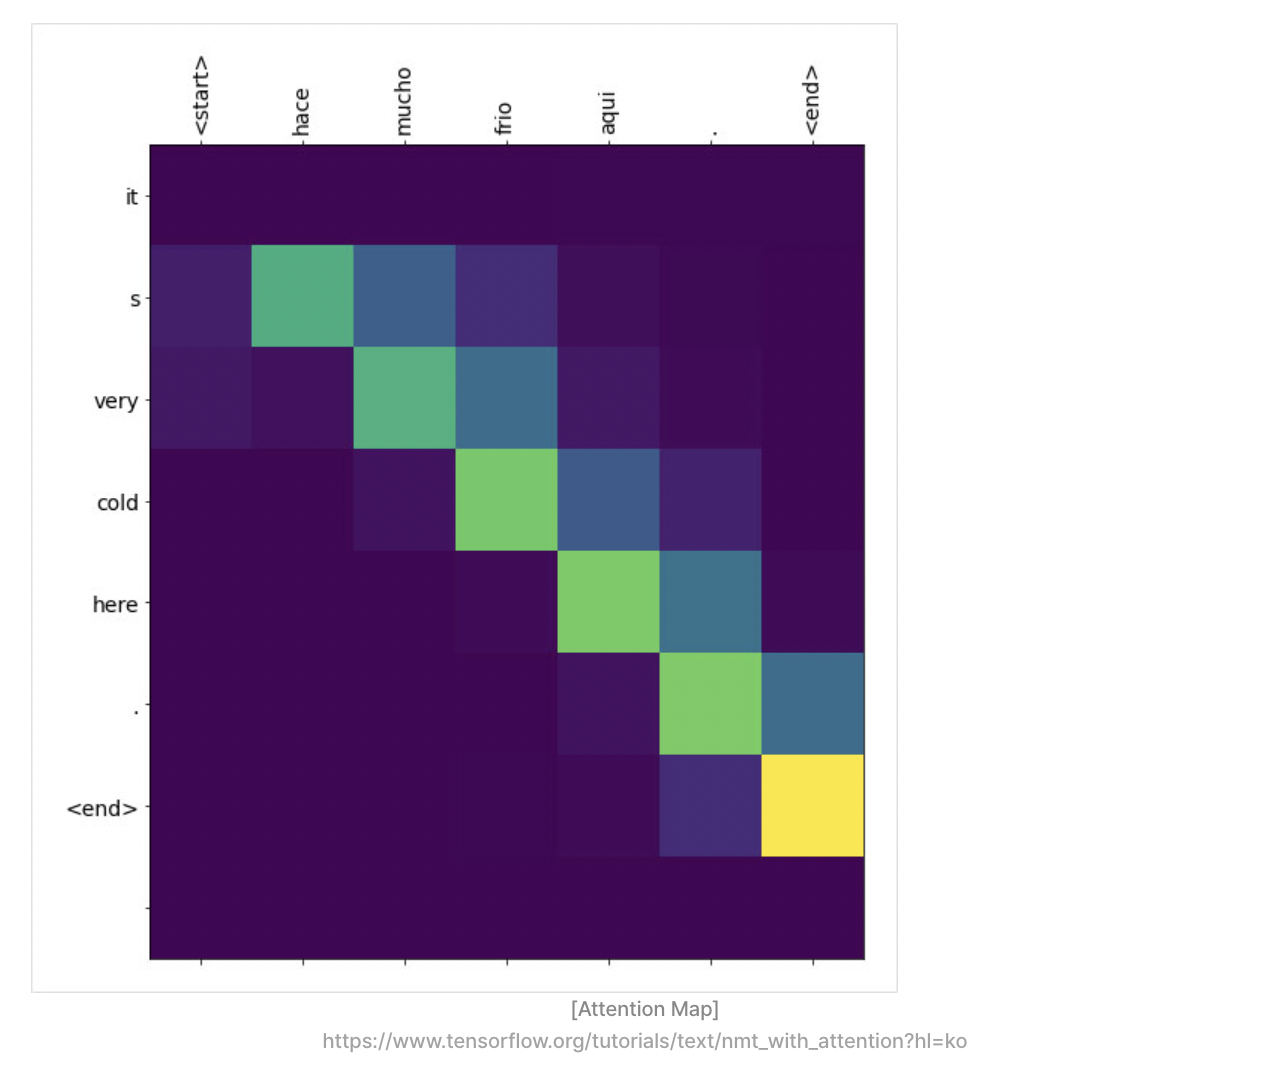


### Luong Attention

In [4]:
class LuongAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(LuongAttention, self).__init__()
    self.W_combine = tf.keras.layers.Dense(units)

  def call(self, H_encoder, H_decoder):
    print("[ H_encoder ] Shape:", H_encoder.shape)

    WH = self.W_combine(H_encoder)
    print("[ W_encoder X H_encoder ] Shape:", WH.shape)

    H_decoder = tf.expand_dims(H_decoder, 1)
    alignment = tf.matmul(WH, tf.transpose(H_decoder, [0, 2, 1]))
    print("[ Score_alignment ] Shape:", alignment.shape)

    attention_weights = tf.nn.softmax(alignment, axis=1)
    print("\n최종 Weight:\n", attention_weights.numpy())

    attention_weights = tf.squeeze(attention_weights, axis=-1)
    context_vector = tf.matmul(attention_weights, H_encoder)

    return context_vector, attention_weights

emb_dim = 512

attention = LuongAttention(emb_dim)

enc_state = tf.random.uniform((1, 10, emb_dim))
dec_state = tf.random.uniform((1, emb_dim))

_ = attention(enc_state, dec_state)

[ H_encoder ] Shape: (1, 10, 512)
[ W_encoder X H_encoder ] Shape: (1, 10, 512)
[ Score_alignment ] Shape: (1, 10, 1)

최종 Weight:
 [[[3.11125303e-04]
  [6.49824739e-01]
  [1.54260155e-02]
  [1.25701842e-03]
  [4.36465325e-06]
  [1.65330712e-02]
  [4.44644783e-03]
  [9.90686268e-02]
  [6.78478032e-02]
  [1.45280764e-01]]]


1. 하나의 weight만 사용 
2. 벡터 공간에 매핑해주는 과정이 없기 때문에 Weight의 크기는 단어 Embedding 크기와 동일해야 연산이 가능하다. 